# GPJM: Simulation Code

## Fitting the GPJM to a complete dataset

Here we fit the GPJM to a simulated dataset to test if the GPJM can explain the data appropriately and if it can recover the latent dynamics governing the data generation process.

## Set up the environment

In [1]:
import numpy as np
import gpflow
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0730 08:12:09.949304 140697629955904 module_wrapper.py:137] From /opt/conda/lib/python3.6/site-packages/gpflow/session_manager.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0730 08:12:10.182625 140697629955904 module_wrapper.py:137] From /opt/conda/lib/python3.6/site-packages/gpflow/training/tensorflow_optimizer.py:157: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0730 08:12:10.194599 140697629955904 module_wrapper.py:137] From /opt/conda/lib/python3.6/site-packages/gpflow/saver/coders.py:80: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.



## Load the model and data generation code

In [2]:
from GPJMv3 import *
from GPJMv3_datagen import *
from GPJMv3_functions import *

## Generate the data

In [3]:
N_t = 100
ts_N = np.linspace(0, N_t, N_t/2+1).reshape(-1, 1)
ts = np.linspace(0, N_t, 3*N_t/2+1).reshape(-1, 1)

ss = np.array([(x,y,z) for x in range(3) for y in range(3) for z in range(3)], dtype = np.float64)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# A dataset is generated using a fixed random seed.
yn0, KIn0, yb, KIb, cs, Kcc, Kcc_conv, Kss = data_gen(ts, ss, [1, 0.75, 0.75], [0.5,0.75], [0.75, 3, 3], [0.015, 0.015], [1, 1])
yn_new, yn_idx, M = downsample_neuraldata(yn0, ts_N, ts)
yn = yn_new.T.ravel().reshape(-1, 1) #yn_new, yn: The actual neural data used in the simulation

### Plot the generated dataset

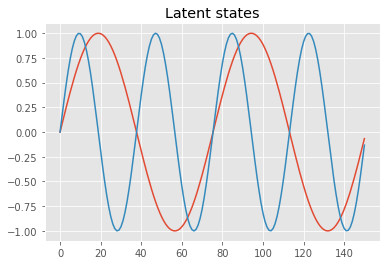

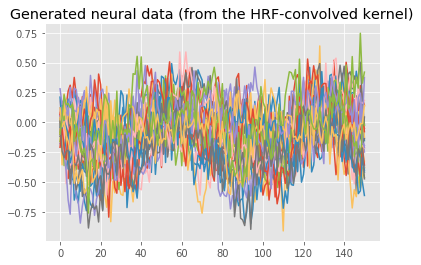

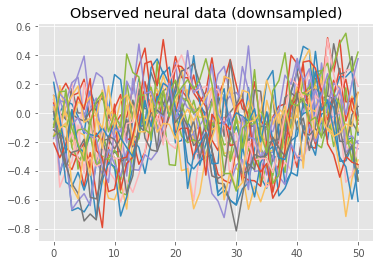

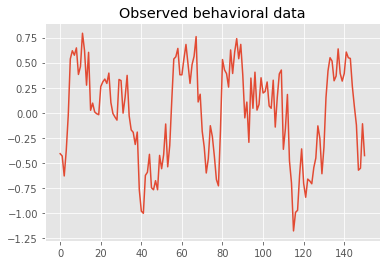

In [7]:
# Latent states
plt.plot(cs)
plt.title("Latent states")
plt.show()

# Generated neural data (not downsampled)
plt.plot(yn0)
plt.title("Generated neural data (from the HRF-convolved kernel)")
plt.show()

# "Observed" neural data (downsampled)
plt.plot(yn_new)
plt.title("Observed neural data (downsampled)")
plt.show()

# Observed beavioral data
plt.plot(yb.T)
plt.title("Observed behavioral data")
plt.show()

## Model fitting

In [8]:
# Initialize the model.
# Note that the noise parameter of the dynamics kernel and the variance parameter of the spatial kernel are fixed.
test2 = GPJMv3(yn, yb.T, ts_N, ts, 2, ss)
test2.likelihood_tX.variance = 1e-6
test2.likelihood_tX.variance.trainable = False
test2.kern_XN.kernel_s.variance.trainable = False

Neural: Sparse / Behavioral: Dense


In [9]:
# Check the initialized model.
test2

,class,prior,transform,trainable,shape,fixed_shape,value
GPJMv3/X,Parameter,None,(none),True,"(151, 2)",True,"[[-0.09565814696096012, -0.5272964923763901], ..."
GPJMv3/kern_XB/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[1.0, 1.0]"
GPJMv3/kern_XB/variance,Parameter,None,+ve,True,(),True,1.0
GPJMv3/kern_XN/kernel_s/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPJMv3/kern_XN/kernel_s/variance,Parameter,None,+ve,False,(),True,1.0
GPJMv3/kern_XN/kernel_t/kernel/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[1.0, 1.0]"
GPJMv3/kern_XN/kernel_t/kernel/variance,Parameter,None,+ve,True,(),True,1.0
GPJMv3/kern_tX/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPJMv3/kern_tX/variance,Parameter,None,+ve,True,(),True,1.0
GPJMv3/likelihood_XB/variance,Parameter,None,+ve,True,(),True,1.0


In [10]:
# Fit the model to the simulated data.
opt = gpflow.train.ScipyOptimizer()
opt.minimize(test2)
print("2-var done")

W0730 08:19:22.673188 140697629955904 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2-var done


In [11]:
# Get the log likelihood.
llk2 = test2.compute_log_likelihood()
print([llk2])

[2184.626101839515]


## Recovery: Two-dimensional Dynamics

In [12]:
# For color-coding the two-dimensional latent dynamics.
# Not a core component of the model and/or analysis.
import matplotlib.colors as colors
import matplotlib.cm as cm
ts_long = np.linspace(0,100,1000)
ts_long.shape

(1000,)

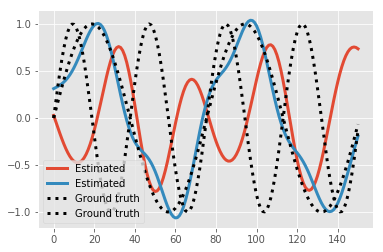

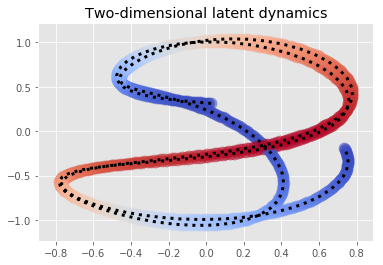

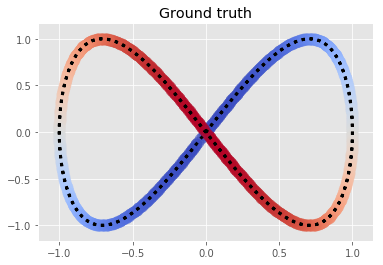

In [13]:
# Extract the estimated dynamics
latent2 = test2.X.value

# Time-series plot
plt.plot(latent2, label="Estimated", linewidth=3)
plt.plot(cs, linestyle=":", c="k", linewidth=3, label="Ground truth")
plt.legend()
plt.show()

# Two-dimensional plots
latent2_0 = np.interp(ts_long, ts.ravel(), latent2[:,0])
latent2_1 = np.interp(ts_long, ts.ravel(), latent2[:,1])

rainbow = plt.get_cmap('coolwarm')
my_norm = colors.Normalize(0, 1)
color_map = cm.ScalarMappable(norm=my_norm, cmap='coolwarm')
col_intensity = np.sin(ts.ravel()/16)**2
col_intensity2 = np.sin(ts_long/16)**2
plt.plot(latent2_0, latent2_1, c="k", linestyle=":", linewidth=3)
for idx in range(ts_long.shape[0]):
    my_col = color_map.to_rgba(col_intensity2[idx], alpha = 0.5)
    plt.scatter(latent2_0[idx], latent2_1[idx], color=my_col, s=125)
plt.title("Two-dimensional latent dynamics")
plt.show()

plt.plot(np.sin(ts_long/8), np.sin(ts_long/4), c="k", linestyle=":", linewidth=3)
for idx in range(ts_long.shape[0]):
    my_col = color_map.to_rgba(col_intensity2[idx], alpha = 0.5)
    plt.scatter(np.sin(ts_long/8)[idx], np.sin(ts_long/4)[idx], color=my_col, s=125)
plt.title("Ground truth")
plt.show()

## Recovery: Neural Data

In [16]:
def recover_neural(m, ts_new):
    import tensorflow as tf
    from numpy.linalg import inv, cholesky
    ts = tf.Session().run(m.ts)
    ts_N = tf.Session().run(m.ts_N)
    ss = tf.Session().run(m.ss)
    Y_N = tf.Session().run(m.Y_N)
    Kstar = recover_Kxn(m, ts_new)
    KttI = recover_Kxn(m, ts) + np.eye(Y_N.shape[0], dtype = np.float64) * m.likelihood_XN.variance.read_value()
    L = cholesky(KttI)
    fmean = Kstar.T.dot(inv(L.T).dot((inv(L)).dot(Y_N)))
    v = inv(L).dot(Kstar)
    Vstar = Kstar - v.T.dot(v)
    sd = np.sqrt(np.diag(Vstar))
    return fmean, fmean.ravel().reshape(ss.shape[0], ts_N.shape[0]).T, Vstar, sd.ravel().reshape(ss.shape[0], ts_N.shape[0]).T

In [17]:
yhat2, yhat2_arr, yhat2_v, yhat2_sd = recover_neural(test2, ts)

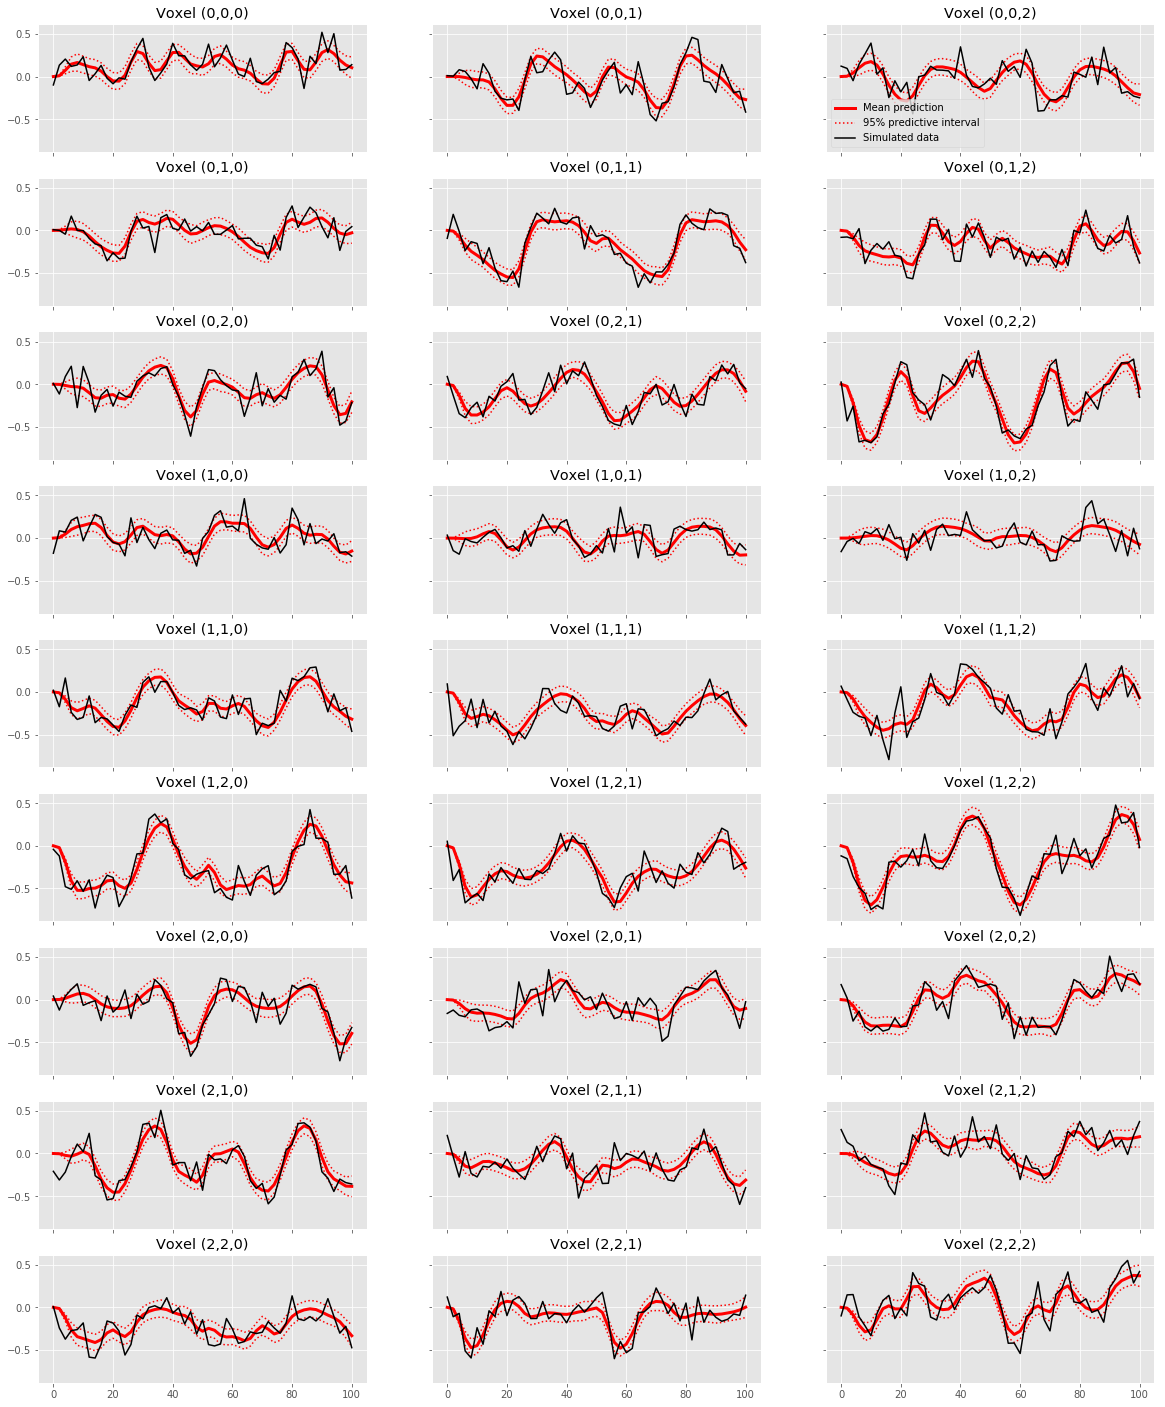

In [18]:
fig, axs = plt.subplots(9, 3, figsize=(20, 25), sharex=True, sharey = True)
for r in range(9):
    for c in range(3):
        voxel_idx = c+r*3
        axs[r,c].plot(ts_N, yhat2_arr[:,voxel_idx], c="r", label="Mean prediction", linewidth=3)
        axs[r,c].plot(ts_N, yhat2_arr[:,voxel_idx] - 1.96 * yhat2_sd[:,voxel_idx], c="r", linestyle=":", label="95% predictive interval")
        axs[r,c].plot(ts_N, yhat2_arr[:,voxel_idx] + 1.96 * yhat2_sd[:,voxel_idx], c="r", linestyle=":")
        axs[r,c].plot(ts_N, yn_new[:,voxel_idx], c="k", label="Simulated data")
        axs[r,c].set_title("Voxel ("+str(int(ss[voxel_idx,0]))+","+str(int(ss[voxel_idx,1]))+","+str(int(ss[voxel_idx,2]))+")")
        if r == 0 and c == 2:
            axs[r,c].legend()

### Recovery: Behavioral Data

In [19]:
bhat2, _, bhat2_ci = recover_behavioral(test2, ts)

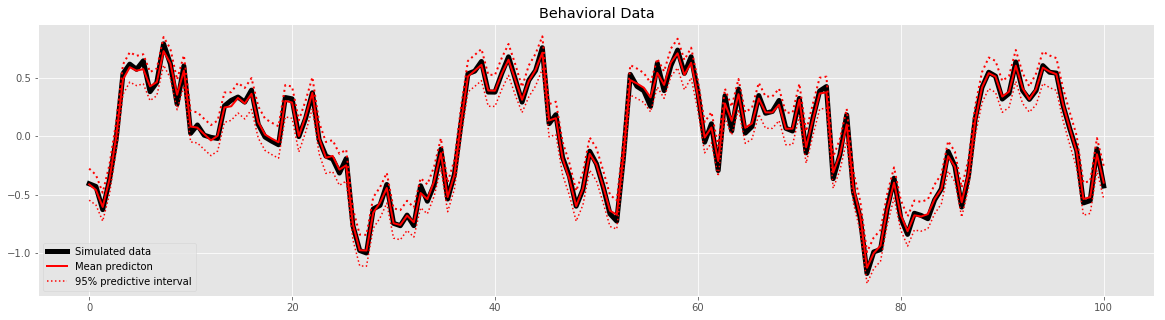

In [20]:
plt.figure(figsize=(20,5))
plt.plot(ts, yb.ravel(), c="k", linewidth = 5, label="Simulated data")
plt.plot(ts, bhat2, c="r", label = "Mean predicton", linewidth=2)
plt.plot(ts, bhat2_ci[:,0], c="r", linestyle = ":", label="95% predictive interval")
plt.plot(ts, bhat2_ci[:,1], c="r", linestyle = ":", linewidth=2)

plt.legend()
plt.title("Behavioral Data")
plt.show()

## Estimated Neural Kernels

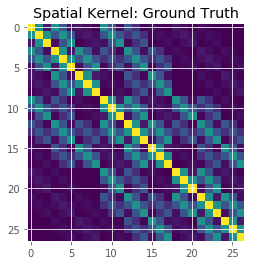

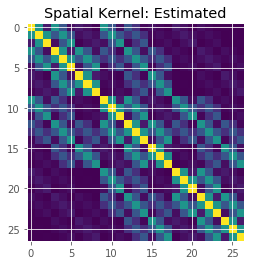

In [23]:
plt.imshow(Kss)
plt.title("Spatial Kernel: Ground Truth")
plt.show()

plt.imshow(test2.kern_XN.kernel_s.compute_K(ss, ss))
plt.title("Spatial Kernel: Estimated")
plt.show()

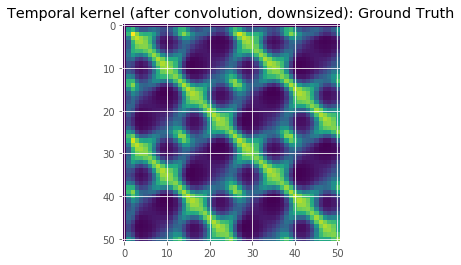

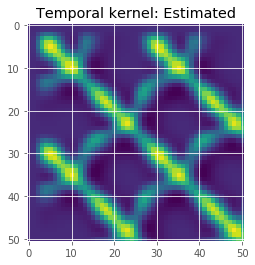

In [24]:
plt.imshow((M.T).dot(Kcc_conv.dot(M)))
np.save("figure-temporalkernel-truth.npy", (M.T).dot(Kcc_conv.dot(M)))
plt.title("Temporal kernel (after convolution, downsized): Ground Truth")
plt.show()
plt.imshow(test2.kern_XN.kernel_t.compute_K(latent2, latent2))
np.save("figure-temporalkernel-estimated.npy", test2.kern_XN.kernel_t.compute_K(latent2, latent2))
plt.title("Temporal kernel: Estimated")
plt.show()

Text(0.5,1,'Spatiotemporal Kernel: Estimated')

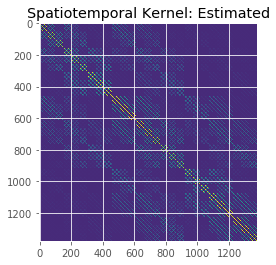

In [25]:
Kss_est = test2.kern_XN.kernel_s.compute_K(ss, ss)
Kxx_est = test2.kern_XN.kernel_t.compute_K(latent2, latent2)
plt.imshow(np.kron(Kss_est, Kxx_est))
plt.title("Spatiotemporal Kernel: Estimated")